## Running on a single computer

In [1]:
%matplotlib inline

In [1]:
from io import StringIO
from matplotlib import pyplot as plt
import csv
import numpy as np
import pandas as pd
import pickle

import warnings
warnings.filterwarnings('ignore')

## Read logs from pickle files


There are two timers measured in the following plots:

* `overall-speed`: the timer that measures the overall data processing speed (including both data loading and weak rules learning),
* `learner-speed`: the timer that only measures the data processing speed while the program is learning weak rules.

In addition, a extra timer is derived which is the difference between the two timers above. It can be seen
as the timer that only mostly measures the data loading speed. It is labeled as `loading-speed` in the plot.

Some observations:

* Learning speed: `r4` > `m4` > `c4` (note that _r4_ and _m4_ perform very close)

* CPU clock frequency: `r4 (2.3)` < `m4 (2.4)` < `c4 (2.9)`

* Memory: `r4 (15.25)` > `m4 (8)` > `c4 (7.5)`

* CPU L3 Cache: `r4 (46)` > `m4 (30)` > `c4 (25)`

* The order of the difference between the speed of `c4` and the speed of `r4` shrinks as the feature size decreases. (**see the last plot which is in log scale**)

Number of cores are equal to 2 on all three instances.


In [13]:
with open("speed_all_feature_sizes.pkl", "rb") as f:
    speed = pickle.load(f)

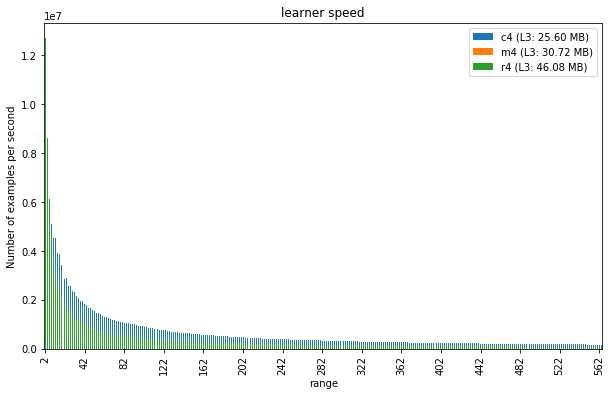

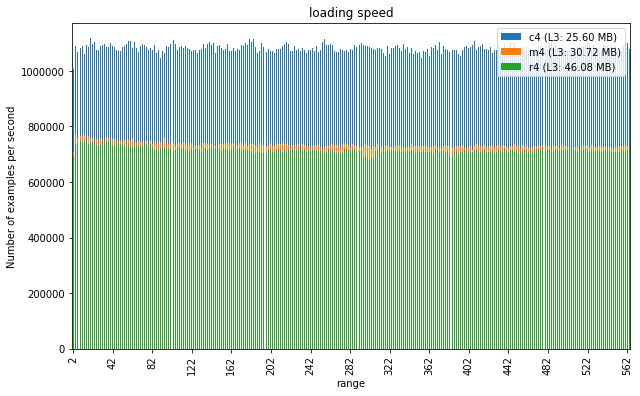

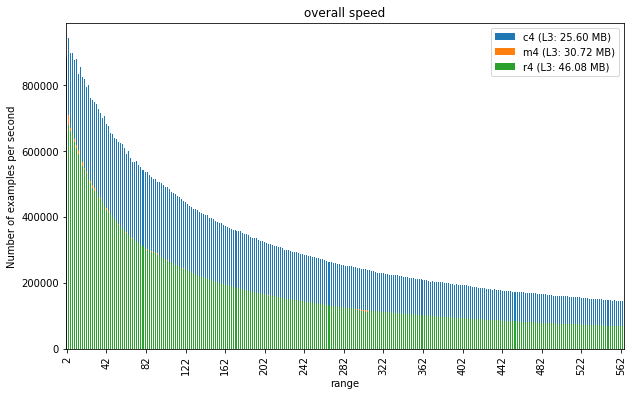

In [14]:
fig_ax = {}
colors = {
    "c4": "#1f77b4",
    "m4": "#ff7f0e",
    "r4": "#2ca02c"
}
l3 = {
    "c4": "25.60 MB",
    "m4": "30.72 MB",
    "r4": "46.08 MB"
}

speed["loading-speed"] = speed["others-speed"]
for ins_type in ["c4", "m4", "r4"]:
    rows = speed[speed["instance-type"] == ins_type] \
            .drop(columns=["overall-duration", "instance-type", "trial"]) \
            .groupby("range")

    means = rows.mean()
    std = rows.std()

    for s in ["learner-speed", "loading-speed", "overall-speed"]:
        if s in fig_ax:
            fig, ax = fig_ax[s]
        else:
            fig, ax = plt.subplots()
            fig.set_figheight(6)
            fig.set_figwidth(10)
            fig_ax[s] = (fig, ax)
            ax.set_ylabel("Number of examples per second")
            ax.set_title(s.replace('-', ' '))
            ax.grid()
        new_key = ins_type + " (L3: {})".format(l3[ins_type])
        means[new_key] = means[s]
        means[[new_key]].sort_index() \
            .plot.bar(yerr=std, ax=ax, color=colors[ins_type])
        x_axis = range(0, means.shape[0], 20)
        ax.set_xticks(x_axis);
        ax.set_xticklabels([(i + 1) * 2 for i in x_axis]);

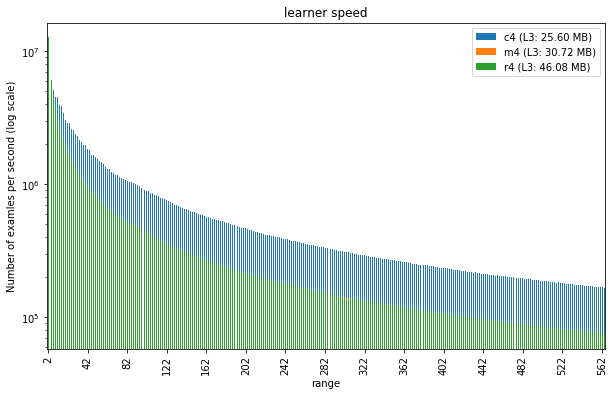

In [15]:
fig_ax["learner-speed"][1].set_yscale("log")
fig_ax["learner-speed"][1].set_ylabel("Number of examles per second (log scale)")
fig_ax["learner-speed"][0]

| Instance  | Memory  | L3 Cache | CPU Cores | CPU Model  | Cost  |
| --------  | ------- | -------- | --------- | ---------  | ----- |
| c4.xlarge | 7.5GB   |   25MB   |   2       | E5-2666 v3 | \$0.2  |
| m4.large  |  8GB    |   30MB   |   2       | E5-2676 v3 | \$0.1  |
| r4.large  | 15.25GB |   46MB   |   2       | E5-2686 v4 | \$0.13 |

## Create pickle files

Run following cells only if new logs are generated.

In [3]:
def create_dataframe(csv_string, col_names):
    return pd.read_csv(StringIO(csv_string), sep=",(?![^{]*\})", quoting=csv.QUOTE_ALL,
                       names=col_names, header=None)


def filter_logs(csv_file, keyword):
    with open(csv_file) as f:
        return ''.join([line for line in f if keyword in line]).strip()


def get_new_tree_info(log_file):
    logs = filter_logs(log_file, "new-tree-info")

    # Wrap tree in quotation marks
    parsed = []
    for line in logs.split('\n'):
        idx = line.find(', Tree')
        line = line[:idx]
        if '"' in line:
            idx = line.find(', "')
            line = line[:idx]
            line += ", {}".format(float(line.rsplit(',', 1)[1])**2)
        # line[-1] = '"{}"'.format(line[-1])
        parsed.append(line)  # ', '.join(line))
    logs = '\n'.join(parsed)

    cols = ["level", "time", "module", "log-type",
            "tree-id", "num-scanned", "gamma", "sum-gamma"]  # , "tree"]
    return create_dataframe(logs, cols)


def get_performance(log_file):
    logs = filter_logs(log_file, "boosting_speed")

    cols = ["level", "time", "module", "log-type",
            "tree-id",
            "overall-duration", "overall-count", "overall-speed",
            "learner-duration", "learner-count", "learner-speed",
            "sampler-duration", "sampler-count", "sampler-speed"]
    return create_dataframe(logs, cols)


def get_true_z(log_file):
    logs = filter_logs(log_file, "validate-only")

    cols = ["level", "time", "module", "log-type",
            "tree-id", "true-z", "auprc"]
    return create_dataframe(logs, cols)

In [4]:
import os

speed = []

base_dir = "/hdd/nips/disk-speed-3/"

invalid = 0
total = 0

for dir_name in ["m4", "c4", "r4"]:
    dir_path = os.path.join(base_dir, dir_name)
    trials = os.listdir(dir_path)
    for trial_name in trials:
        trial_path = os.path.join(dir_path, trial_name)
        files = os.listdir(trial_path)
        for file_name in files:
            file_path = os.path.join(trial_path, file_name)
            range_size = None
            with open(file_path) as f:
                
                for line in f:
                    line = line.strip()
                    if "rust_boost, range" in line:
                        _, left, right = line.rsplit(',', 2)
                        left = int(left)
                        right = int(right)
                        range_size = right - left
                        break
            total += 1
            if range_size is None:
                invalid += 1
                # print(file_path)
                continue
            _speed = get_performance(file_path)
            _speed["range"] = range_size
            _speed["instance-type"] = dir_name
            _speed["trial"] = int(file_name.rsplit('.', 1)[0].rsplit('-', 1)[1])
            try:
                speed.append(_speed.iloc[int(_speed.shape[0] / 2)].to_frame().T)
            except:
                invalid += 1

speed = pd.concat(speed)
speed["others-duration"] = speed["overall-duration"] - speed["learner-duration"]
speed["others-speed"] = speed["overall-count"] / speed["others-duration"]
invalid

0

In [36]:
speed.to_pickle("speed_all_feature_sizes.pkl")